In [1]:
#%matplotlib notebook
%matplotlib inline

In [2]:
from ipywidgets import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys

# path hack for relative import in jupyter notebook
CELLTYPES = os.path.dirname(os.path.abspath(''))
sys.path.append(CELLTYPES)

from singlecell.singlecell_linalg import sorted_eig
from utils.file_io import RUNS_FOLDER, INPUT_FOLDER
from singlecell.singlecell_simsetup import singlecell_simsetup
from multicell.multicell_simulate import Multicell
from multicell.analysis_gamma import check_still_fp

manyruns = RUNS_FOLDER + os.sep + 'multicell_manyruns'

Appended to sys path I:\Development\Repositories\biomodels\celltypes
DYNAMICS_FIXED_UPDATE_ORDER: True
DYNAMICS_FIXED_UPDATE_ORDER: True


c:\users\matts\appdata\local\programs\python\python38\lib\site-packages\proplot\colors.py:976: ProPlotWarning: Shifting non-cyclic colormap 'acton_truncate'. Use cmap.set_cyclic(True) or Colormap(..., cyclic=True) to suppress this warning.
c:\users\matts\appdata\local\programs\python\python38\lib\site-packages\proplot\colors.py:976: ProPlotWarning: Shifting non-cyclic colormap 'Sunrise_truncate'. Use cmap.set_cyclic(True) or Colormap(..., cyclic=True) to suppress this warning.
c:\users\matts\appdata\local\programs\python\python38\lib\site-packages\proplot\colors.py:976: ProPlotWarning: Shifting non-cyclic colormap 'Sunset_truncate'. Use cmap.set_cyclic(True) or Colormap(..., cyclic=True) to suppress this warning.


In [3]:
NOTEBOOK_OUTDIR = RUNS_FOLDER + os.sep + 'explore' + os.sep + 'nb_spectrum'
os.makedirs(NOTEBOOK_OUTDIR, exist_ok=True)

# Notebook functions

In [4]:
def J_multicell_from_class(multicell, gamma, plot=False):
    J_multicell = multicell.build_J_multicell(gamma=gamma, plot=plot)
    return J_multicell

def J_multicell_manual(gamma, J, A, W, autocrine=False, plot=False):
    num_genes = J.shape[0]
    num_cells = A.shape[0]
    
    W_scaled = gamma * W
    W_scaled_sym = 0.5 * (W_scaled + W_scaled.T)

    # Term A: self interactions for each cell (diagonal blocks of multicell J_block)
    if autocrine:
        J_diag_blocks = np.kron(np.eye(num_cells), J + W_scaled_sym)
    else:
        J_diag_blocks = np.kron(np.eye(num_cells), J)

    # Term B of J_multicell (cell-cell interactions)
    adjacency_arr_lowtri = np.tril(A, k=-1)
    adjacency_arr_uptri = np.triu(A, k=1)
    J_offdiag_blocks = np.kron(adjacency_arr_lowtri, W_scaled.T) \
                       + np.kron(adjacency_arr_uptri, W_scaled)

    # build final J multicell matrix
    J_multicell = J_diag_blocks + J_offdiag_blocks

    if plot:
        plt.imshow(J_multicell)
        plt.title('Multicell gene interaction matrix')
        plt.show()
    return J_multicell

In [45]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_evals_rank(ax, evals, gamma, eval_indices):
    x_axis = eval_indices  # possible use instead np.arange(len(eval_indices)), and change the axis label
    evals = evals[eval_indices]
    ax.plot(x_axis, evals, '--o', alpha=0.6, label='$\gamma=%.2f$' % gamma)
    ax.axhline(0)
    
def plot_evals_hist(ax, evals, gamma, nbins=120):
    #plt.scatter(range(len(evals)), evals, marker='o', alpha=0.6, edgecolors='k', label='$\gamma=%.2f$' % gamma)
    ax.hist(evals, alpha=0.6, bins=nbins, label='$\gamma=%.2f$' % gamma) 

def get_and_plot_evals(J_multicell, gamma):
    evals, _ = sorted_eig(J_multicell, take_real=True, big_to_small=True)
    #plt.scatter(range(len(evals)), evals, marker='o', alpha=0.6, edgecolors='k', label='$\gamma=%.2f$' % gamma)
    plt.plot(range(len(evals)), evals, '--o', alpha=0.6, label='$\gamma=%.2f$' % gamma)
    
def show_evecs_range(evecs, evals, spin_indices, eval_indices, reshape_tuple=None, forcelims=False, figsize=(10,10), norm=True, imshow=True, ax=None):
    if forcelims: assert imshow  # TODO clip for other style?
    # assumes already sorted largest to smallest
    print(evecs.shape)
    arr = evecs[:, eval_indices]
    arr = arr[spin_indices, :]
    
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    if norm:
        arr_caps = np.amax(np.abs(arr), axis=0)
        arr = arr / arr_caps  # absmax of each eigenvector is stretched to +1      
    
    if imshow:
        aspect='auto'
        if forcelims:
            absmax = np.max(np.abs(arr))
            mappable = ax.imshow(arr, interpolation='none', cmap='coolwarm_r', vmin=-absmax, vmax=absmax, aspect=aspect)
        else:
            mappable = ax.imshow(arr, interpolation='none', cmap='coolwarm_r', aspect=aspect)
            
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="2%", pad=0.05)
        #fig.colorbar(mappable, cax=cax)

        #ax.set_aspect(0.4375)
        #cax.set_aspect(8.75)
        
    else:
        for idx in indices:
            ax.bar(np.arange(evecs.shape[0]), arr[:, idx], label='$\lambda_{%d}=%.3f$' % (idx, evals[idx]))
        ax.set_xlabel('Gene index')
        ax.set_ylabel('Eigenvector value')
        ax.legend()
    
    # TODO functionalize this, else the ticks will be 0 to K, which index the arrays: spin_indices, eval_indices
    """
    ax.set_xticks(eval_indices)
    ax.set_yticks(spin_indices)"""
    
    return ax

def plot_all_4(J, W, A, J_multicell, 
               vlim_global=True, cmap=None, add_grid=True, cbar=False):
    if cmap is None:
        cmap = 'RdBu'  # bwr Purples

    fig, ax = plt.subplots(2,2, figsize=(10,9))

    plotdict = {(0,0): {'arr': J, 
                        'label': 'Gene #',
                        'title': r'$\bf{J_0}$', 
                        'lw': 2},
                (0,1): {'arr': W, 
                        'label': 'Gene #',
                        'title': r'$\bf{W}$',
                        'lw': 2},
                (1,0): {'arr': A, 
                        'label': 'Cell #',
                        'title': r'$\bf{A}$',
                        'lw': 1},
                (1,1): {'arr': J_multicell, 
                        'label': '(Multicell) Gene #',
                        'title': r'$\bf{J_{multicell} = I \otimes J_0 + A \otimes W}$',
                        'lw': 1},
               }
    
    if vlim_global:
        vmin = min(np.min(a) for a in [J, W, A, J_multicell])
        vmax = max(np.max(a) for a in [J, W, A, J_multicell])
        print('Found global vlims:', vmin, vmax)
    else:
        vmin = -1.0 #None
        vmax = 1.0  #None
    
    for k, v in plotdict.items():    
        sc = ax[k].imshow(v['arr'], cmap=cmap, vmin=vmin, vmax=vmax, interpolation='none')
        ax[k].set_title(v['title'])
        ax[k].set_xlabel(v['label'])
        ax[k].set_ylabel(v['label'])
    
        if add_grid:
            ax[k].set_xticks(np.arange(-.5, v['arr'].shape[0], 1), minor=True)
            ax[k].set_yticks(np.arange(-.5, v['arr'].shape[0], 1), minor=True)
            ax[k].grid(which='minor', color='w', linestyle='-', linewidth=v['lw'])
    
    
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    if cbar:
        plt.colorbar(sc)
    plt.savefig(NOTEBOOK_OUTDIR + os.sep + 'plot_all_4.svg')
    plt.show()
    
    
    
def plot_evecs_and_evals_stacked(evecs, evals, eval_indices, spin_indices, gamma, num_cells, num_genes, title=None, reshape_tuple=None, forcelims=False, figsize=(10,10), imshow=True):
    fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)
    
    # Plot evecs above on ax 1 - TODO - vis flag to stretch each eigenvector separately to have max abs value 1
    show_evecs_range(evecs, evals, spin_indices, eval_indices, reshape_tuple=None, forcelims=False, imshow=True, ax=ax[0])
    ax[0].set_xlabel('rank of $\lambda$')
    ax[0].set_ylabel('spin index')
    linecol = 'black'

    # Plot evals below on ax 2
    plot_evals_rank(ax[1], evals, gamma, eval_indices)
    ax[1].set_xlabel('rank of $\lambda$')
    ax[1].set_ylabel('$\lambda$')
    
    if title is not None:
        ax[0].set_title(title_gamma)
        #plt.suptitle(title)
    
    # Vertical lines (TODO REMOVE - used for axis alignment)
    if len(eval_indices) < 100: 
        vlw = 1.0
        #for k in range(1, num_genes * num_cells):
        for k in range(1, len(eval_indices)):
            assert eval_indices[0] == 0 and eval_indices[1] == 1
            g_pos = k - 0.5
            ax[0].axvline(g_pos, 0, 1, color=linecol, lw=vlw)
            ax[1].axvline(g_pos, 0, 1, color=linecol, lw=vlw)
    # Horizontal lines
    if len(spin_indices) < 900:  # should mnaybe replace by len(indices) < 100
        hlw = 1.0
        for c in range(1, int(len(spin_indices)/num_genes)):
            assert spin_indices[0] == 0 and spin_indices[1] == 1
            c_pos = num_genes * c - 0.5
            ax[0].axhline(c_pos, 0, 1, color=linecol, lw=hlw)

    #plt.subplots_adjust(hspace=0.3, wspace=0.3)
    #plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    fpath = NOTEBOOK_OUTDIR + os.sep + 'manual_Jmulticell_spec_g%.5f' % gamma
    plt.savefig(fpath + '.png', bbox_inches='tight')
    plt.savefig(fpath + '.pdf', bbox_inches='tight')
    

In [6]:
def plot_evec_as_lattice(evec, num_cells, num_genes, sidelength, norm=True):
    ndim = num_cells * num_genes
    assert sidelength ** 2 == num_cells
    assert len(evec.shape) == 1
    assert evec.shape[0] == ndim
    
    if norm:
        arr_caps = np.amax(np.abs(evec), axis=0)  # could simplify, its not 2D array
        evec = evec / arr_caps  # absmax of each eigenvector is stretched to +1    
    
    # morph array into correct shape (first lattice site has genes 1 to N, next has N+1 to N, etc.)
    sidelength_genes = sidelength * num_genes
    arr = evec.reshape(sidelength, sidelength, num_genes, order='C')
    arr_imshow = np.zeros((sidelength_genes, sidelength))
    for idx in range(sidelength):
        i = num_genes * idx
        j = num_genes * (idx + 1)
        arr_imshow[i:j, :] = arr[idx, :, :].T
    
    plt.figure(figsize=(20,10))
    ax = plt.gca()
    mappable = ax.imshow(arr_imshow, interpolation='none', cmap='coolwarm_r', aspect='auto')
    
    # add line dividers for each cell
    vlw = 4.0
    hlw = 4.0
    linecol = 'k'
    for k in range(1, sidelength):
        ax.axvline(k - 0.5, 0, 1, color=linecol, lw=vlw)
        ax.axhline(k * num_genes  - 0.5, 0, 1, color=linecol, lw=hlw)
    
    fpath = NOTEBOOK_OUTDIR + os.sep + 'manual_Jmulticell_evec_as_lattice'
    plt.savefig(fpath + '.png', bbox_inches='tight')
    plt.savefig(fpath + '.pdf', bbox_inches='tight')

# (LOCAL) Build multicell object

In [7]:
# 1) create simsetup
main_seed = 0  #np.random.randint(1e6)
curated = True
random_mem = False        # TODO incorporate seed in random XI in simsetup/curated
random_W = True          # TODO incorporate seed in random W in simsetup/curated

#W_override_path = None

# ===========================================
# aka Wrandom0
W_override_path = INPUT_FOLDER + os.sep + 'manual_WJ' + os.sep + 'simsetup_W_9_maze.txt'
# ===========================================

#W_override_path = INPUT_FOLDER + os.sep + 'manual_WJ' + os.sep + 'simsetup_W_9_W1pattern.txt'
#W_override_path = INPUT_FOLDER + os.sep + 'manual_WJ' + os.sep + 'simsetup_W_2018mazeUpTri.txt'
#W_override_path = INPUT_FOLDER + os.sep + 'manual_WJ' + os.sep + 'simsetup_W_9_manual_ABv2.txt'
#W_override_path = INPUT_FOLDER + os.sep + 'manual_WJ' + os.sep + 'simsetup_W_9_W7maze.txt'

simsetup_main = singlecell_simsetup(
    unfolding=True, random_mem=random_mem, random_W=random_W, curated=curated, housekeeping=0)
if W_override_path is not None:
    print('Note: in main, overriding W from file...')
    explicit_W = np.loadtxt(W_override_path, delimiter=',')
    simsetup_main['FIELD_SEND'] = explicit_W
    
print("\nsimsetup checks:")
print("\tsimsetup['N'],", simsetup_main['N'])
print("\tsimsetup['P'],", simsetup_main['P'])
with np.printoptions(precision=3, suppress=True):
    print("simsetup J\n", simsetup_main['J'])
print("simsetup W\n", simsetup_main['FIELD_SEND'])

Using unfolding npz
loading npz of arr genes cells at I:\Development\Repositories\biomodels\celltypes\input\unfolding\unfold_expC1_mems_genes_types_signals.npz ...
loaded arr, genes, cells, signals: (9, 3) (9,) (3,) (9, 9)
CURATED selected, resetting simsetup vars
Note network method for interaction_matrix() is projection
Note: in main, overriding W from file...

simsetup checks:
	simsetup['N'], 9
	simsetup['P'], 3
simsetup J
 [[ 0.     0.333  0.333 -0.    -0.    -0.    -0.    -0.    -0.   ]
 [ 0.333  0.     0.333 -0.    -0.    -0.    -0.    -0.    -0.   ]
 [ 0.333  0.333  0.    -0.    -0.    -0.    -0.    -0.    -0.   ]
 [-0.    -0.    -0.     0.     0.333  0.333  0.     0.     0.   ]
 [-0.    -0.    -0.     0.333  0.     0.333  0.     0.     0.   ]
 [-0.    -0.    -0.     0.333  0.333  0.     0.     0.     0.   ]
 [-0.    -0.    -0.    -0.    -0.    -0.     0.     0.333  0.333]
 [-0.    -0.    -0.    -0.    -0.    -0.     0.333  0.     0.333]
 [-0.    -0.    -0.    -0.    -0.    -0. 

In [8]:
# setup 2.1) multicell sim core parameters
search_radius = 1
num_cells = 10**2           # global GRIDSIZE
total_steps = 31            # global NUM_LATTICE_STEPS
plot_period = 10

flag_state_int = False
flag_blockparallel = False
beta = np.Inf
#gamma = 0.0  #1.0               # i.e. field_signal_strength
gamma = 0.0  # 1.0               # i.e. field_signal_strength
kappa = 0.0                # i.e. field_applied_strength

# setup 2.2) graph options
autocrine = False
graph_style = 'lattice_square'
graph_kwargs = {'search_radius': search_radius,
                'periodic': True,
                'initialization_style': 'dual'}

# setup 2.6) optionally load an initial state for the lattice
load_manual_init = False
init_state_path = None
if load_manual_init:
    init_state_path = INPUT_FOLDER + os.sep + 'manual_graphstate' + os.sep + 'X_7.txt'
    print('Note: in main, loading init graph state from file...')

# 3) prep args for Multicell class instantiation
multicell_kwargs = {
    'seed': main_seed,
    'beta': beta,
    'total_steps': total_steps,
    'num_cells': num_cells,
    'flag_blockparallel': flag_blockparallel,
    'graph_style': graph_style,
    'graph_kwargs': graph_kwargs,
    'autocrine': autocrine,
    'gamma': gamma,
    'exosome_string': "no_exo_field",
    'exosome_remove_ratio': 0.0,
    'kappa': kappa,
    'field_applied': None,
    'flag_housekeeping': False,
    'flag_state_int': flag_state_int,
    'plot_period': plot_period,
    'init_state_path': init_state_path,
    'run_subdir': None  #'s%d' % main_seed
}

# 3) instantiate
multicell = Multicell(simsetup_main, verbose=True, **multicell_kwargs)
ndim = multicell.num_genes * multicell.num_cells

Initializing Multicell class object...
Building dual lattice with types [0, 1]
call to TEMP_graph_state_from_lattice() -- remove this function
field_applied.shape: (900, 31)
done


#### Plot matrices for fixed params

Found global vlims: -0.9308 1.0


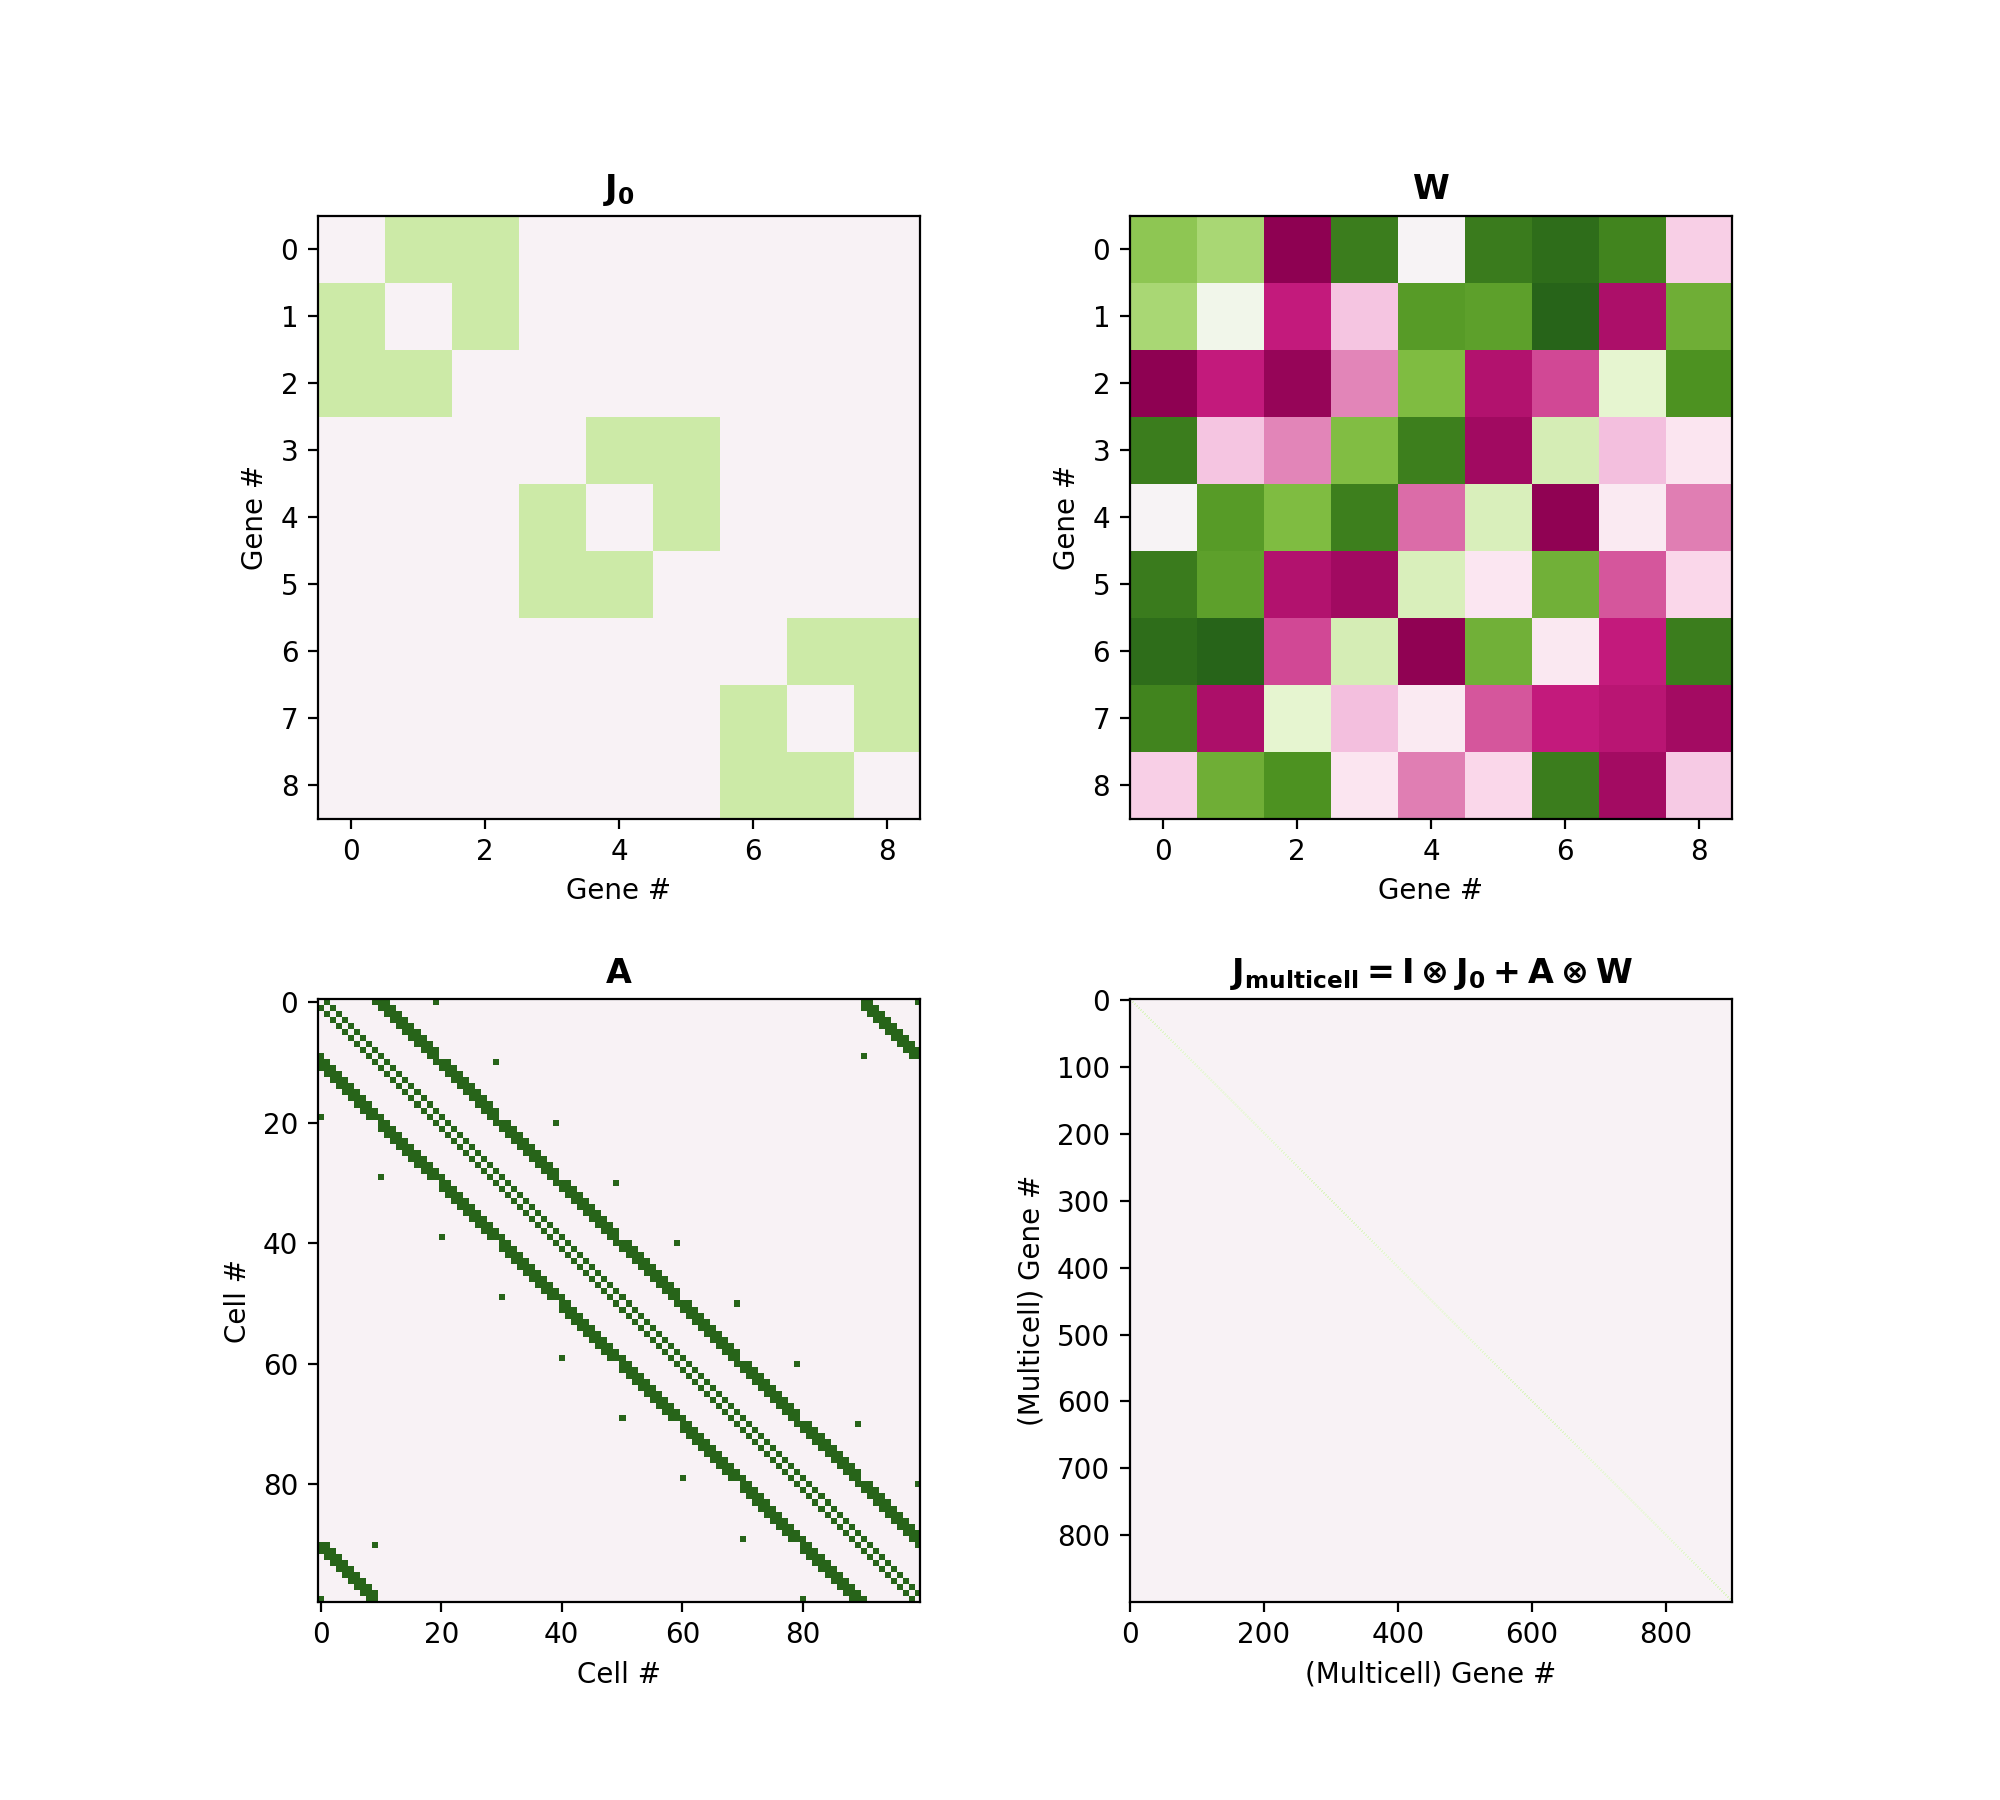

In [9]:
plot_all_4(multicell.matrix_J, multicell.matrix_W, multicell.matrix_A, multicell.matrix_J_multicell) 

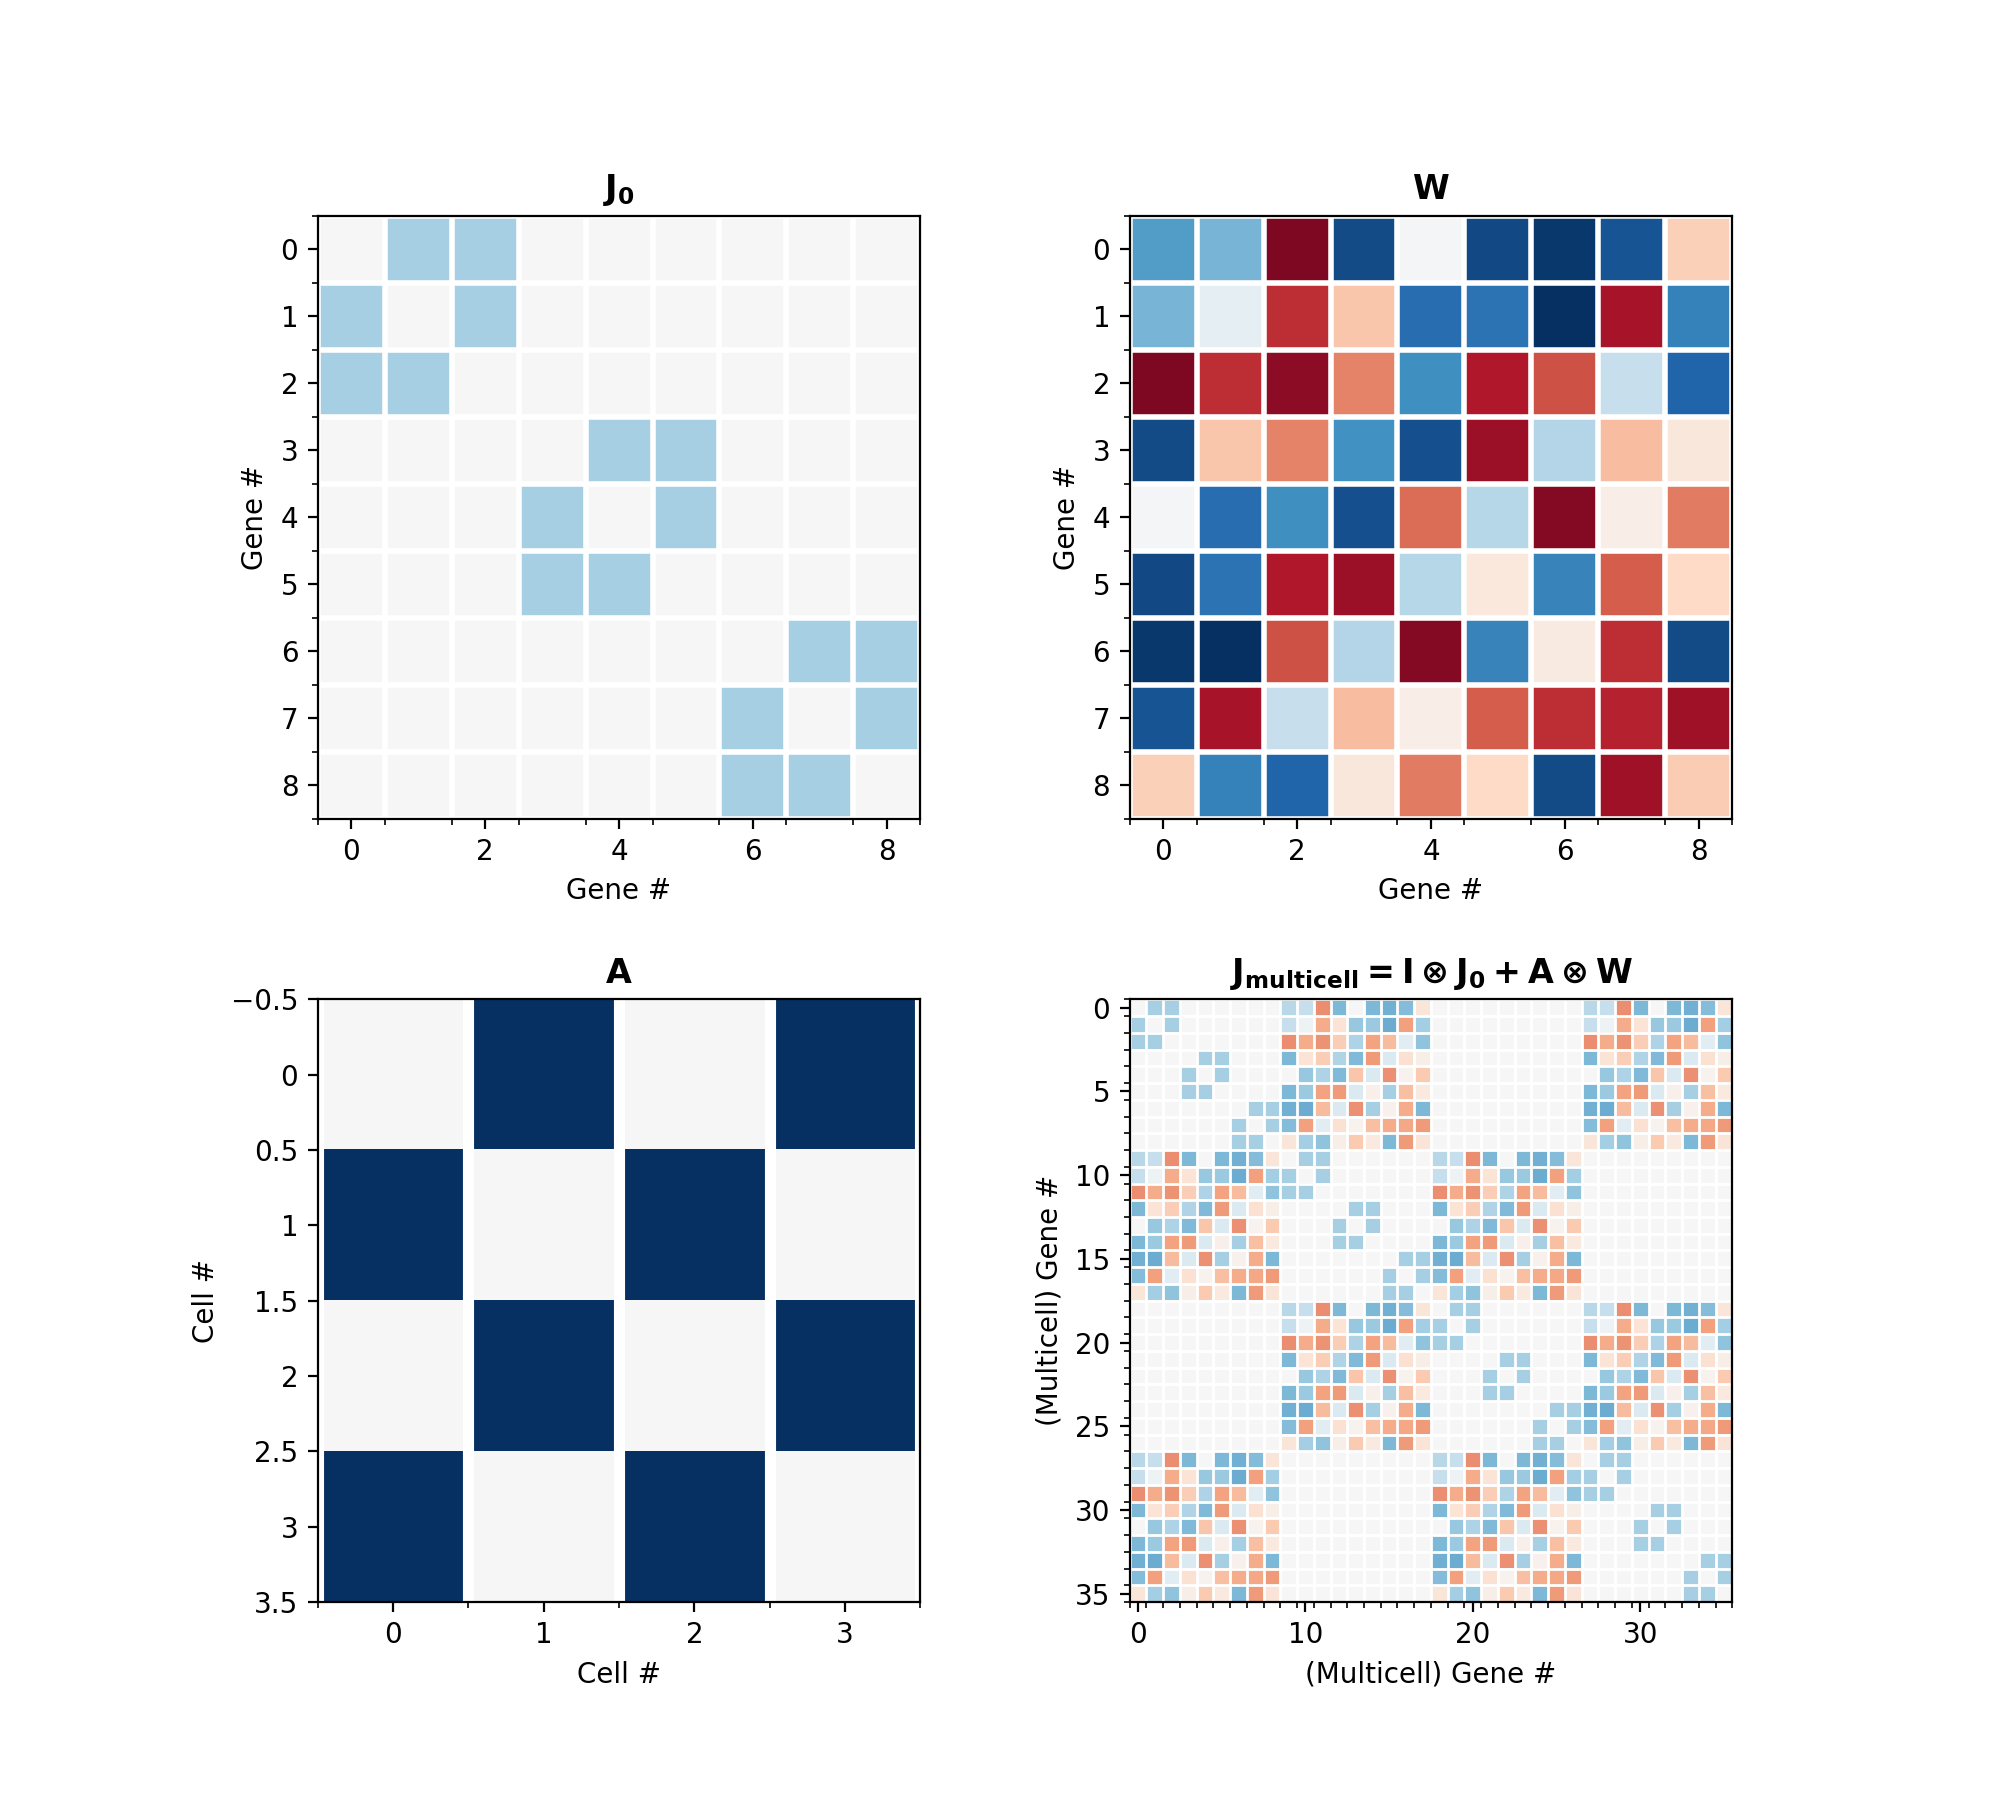

In [46]:
manual_gamma = 0.5
manual_A = np.array([
    [0,1,0,1],
    [1,0,1,0],
    [0,1,0,1],
    [1,0,1,0]
])
manual_M = J_multicell_manual(
    manual_gamma, 
    multicell.matrix_J, 
    manual_A, 
    multicell.matrix_W, 
    autocrine=False, plot=False)

plot_all_4(multicell.matrix_J, 
           multicell.matrix_W, 
           manual_A, 
           manual_M,
           cmap='RdBu',
           vlim_global=False,
           cbar=False)

#### Plot spectra (rank) for fixed params

In [ ]:
eval_indices_full = np.arange(ndim)
evalsdict = {(0,0): {'arr': multicell.matrix_J, 
                     'title': r'Spectrum: $\bf{J_0}$',
                     'evals': sorted_eig(multicell.matrix_J, take_real=True, big_to_small=True)[0],
                     'eval_indices': np.arange(multicell.num_genes)
                    },
             (0,1): {'arr': multicell.matrix_W, 
                     'title': r'Spectrum: $\bf{W}$',
                     'evals': sorted_eig(multicell.matrix_W, take_real=True, big_to_small=True)[0],
                     'eval_indices': np.arange(multicell.num_genes)
                    },
             (1,0): {'arr': multicell.matrix_A, 
                     'title': r'Spectrum: $\bf{A}$',
                     'evals': sorted_eig(multicell.matrix_A, take_real=True, big_to_small=True)[0],
                     'eval_indices': np.arange(multicell.num_cells)
                    },
             (1,1): {'arr': multicell.matrix_J_multicell, 
                     'title': r'Spectrum: $\bf{J_{multicell} = I \otimes J_0 + A \otimes W}$',
                     'evals': sorted_eig(multicell.matrix_J_multicell, take_real=True, big_to_small=True)[0],
                     'eval_indices': eval_indices_full
                    },
            }

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,9))
xlabel = 'rank of $\lambda$'
ylabel = '$\lambda$'

for k, v in evalsdict.items():    
    plot_evals_rank(ax[k], v['evals'], gamma, v['eval_indices'])
    ax[k].set_title(v['title'])
    ax[k].set_xlabel(xlabel)
    ax[k].set_ylabel(ylabel)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,9))
xlabel = '$\lambda$'
ylabel = 'Events'

for k, v in evalsdict.items():    
    plot_evals_hist(ax[k], v['evals'], gamma, nbins=50)
    ax[k].set_title(v['title'])
    ax[k].set_xlabel(xlabel)
    ax[k].set_ylabel(ylabel)
    #ax[k].set_xlim(10,24)
    #ax[k].set_xlim(18.75,19)
    #ax[k].set_ylim(0,10)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

**Plot eigenvectors**

In [ ]:
J = multicell.matrix_J
A = multicell.matrix_A
W = multicell.matrix_W

A_alternate = np.ones(10)
A_to_try = A
#A_to_try = A_alternate

num_cells_loc = A_to_try.shape[0]
num_genes_loc = W.shape[0]
ndim = num_cells_loc * num_genes_loc
#indices = np.arange(ndim)
eval_indices = np.arange(ndim)
spin_indices = np.arange(ndim)

gamma_space = [0.0, 1.0]#, 0.07] #, 0.08]#, 0.09]

for idx, g in enumerate(gamma_space):
    M_gamma = J_multicell_manual(g, J, A_to_try, W, autocrine=autocrine, plot=False)
    # TODO STORE THESE OUTPUTS
    M_gamma_evals, M_gamma_evecs = sorted_eig(M_gamma, take_real=True, big_to_small=True)
    
    title_gamma = r'Spectrum: $\bf{J_{multicell} = I \otimes J_0 + A \otimes W}$, $\gamma=%.4f$' % g
    
    plot_evecs_and_evals_stacked(M_gamma_evecs, M_gamma_evals, eval_indices, spin_indices, g, num_cells_loc, num_genes_loc, title=title_gamma, reshape_tuple=None, forcelims=False, figsize=(10,10), imshow=True)    

In [ ]:
# plot just the last one from the loop

g = gamma_space[-1]  # must be -1
title_gamma = r'Spectrum: $\bf{J_{multicell} = I \otimes J_0 + A \otimes W}$, $\gamma=%.4f$' % g

eval_indices = np.arange(0,50)
spin_indices = np.arange(0,90)
#spin_indices = np.arange(ndim)
plot_evecs_and_evals_stacked(M_gamma_evecs, M_gamma_evals, eval_indices, spin_indices, g, num_cells_loc, num_genes_loc, title=title_gamma, reshape_tuple=None, forcelims=False, figsize=(10,10), imshow=True)    


In [ ]:
# look at eigenvectors for specific gamma balue
gamma_test = 100.0
M_gamma_evals, M_gamma_evecs = sorted_eig(M_gamma, take_real=True, big_to_small=True)


v1 = M_gamma_evecs[:,0]
cap = np.max(np.abs(v1))
v1s = v1 / cap
print(v1)
print(np.min(v1), np.max(v1))
print(v1s)
print(np.min(v1s), np.max(v1s))

In [ ]:
evec = M_gamma_evecs[:, 0]
sidelength = 10
plot_evec_as_lattice(evec, num_cells_loc, num_genes_loc, sidelength, norm=True)

In [ ]:
evec = M_gamma_evecs[:, 12]
hvec = np.dot(M_gamma, evec)

sign_evec = np.sign(evec)
hvec_signed = np.dot(M_gamma, sign_evec)
sign_hvec_signed = np.sign(hvec_signed)
error_signed = sign_hvec_signed - sign_evec

plot_evec_as_lattice(error_signed, num_cells_loc, num_genes_loc, sidelength, norm=True)

## Plot particular state as eigenvector decomposition in lattice format

In [ ]:
# see explore_aligned.ipynb notebook

## (Widget) Load manyruns template: Vary gamma, all else fixed

*Example widget:* https://stackoverflow.com/questions/44329068/jupyter-notebook-interactive-plot-with-widgets

In [ ]:
# CHOICES
manyruns_label = 'W1_gamma1.00_10k_periodic_R1_p3_M100_machineEps'
#manyruns_label = 'Wrandom0_gamma0.00_10k_p3_M100'
dy = 0.05
gamma_max = 2.0

# 1) access specific manyrun (gives access to multicell pkl file)
manyruns_dirpath = manyruns + os.sep + manyruns_label
multicell_pkl_path = manyruns_dirpath + os.sep + 'multicell_template.pkl'
with open(multicell_pkl_path, 'rb') as pickle_file:
    multicell_template = pickle.load(pickle_file)  # unpickling multicell object

# 2) construct gamma range
gamma_vals = np.arange(0.0, gamma_max + dy, dy)

In [ ]:
# settings
show_legend = True
init = 0.0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# labels
fig.suptitle(r'Spectrum of $J_{\mathrm{multicell}}$ for varying $\gamma$', fontsize=12)
plt.title('Run: %s' % manyruns_label, fontsize=10)
plt.xlabel('rank of $\lambda$')
plt.ylabel('$\lambda$')
# grid settings
plt.grid(True)
plt.rc('axes', axisbelow=True)
# zero line
plt.axhline(0)

def update(gamma = 1.0):
    J_multicell = J_multicell_from_class(multicell_template, gamma, plot=False)
    get_and_plot_evals(J_multicell, gamma)
    if show_legend:
        plt.legend()
    plt.xlim(0,20)
    return

interact(update, gamma=widgets.Dropdown(options=gamma_vals, value=init))

In [ ]:
#interact(update, gamma=widgets.FloatSlider(min=0, max=30, step=0.05, value=0))
interact(update, gamma=widgets.FloatSlider(min=0, max=gamma_max, step=dy, value=0))

**Plot eigenvectors**

In [ ]:
indices = np.arange(0,10)

In [ ]:
gamma_check = 0.0
J_multicell = J_multicell_from_class(multicell, gamma_check, plot=False)
evals, evecs = sorted_eig(J_multicell, take_real=True, big_to_small=True)
show_evecs_range(evecs, evals, indices, forcelims=False, figsize=(10,10), imshow=True)

In [ ]:
gamma_check = 0.0
J_multicell = J_multicell_from_class(multicell, gamma_check, plot=False)
evals, evecs = sorted_eig(J_multicell, take_real=True, big_to_small=True)
show_evecs_range(evecs, evals, indices, forcelims=False, figsize=(10,10), imshow=False)

In [ ]:
gamma_check = 0.05
J_multicell = J_multicell_from_class(multicell, gamma_check, plot=False)
evals, evecs = sorted_eig(J_multicell, take_real=True, big_to_small=True)
show_n_evecs(evecs, evals, indices, forcelims=True, imshow=True)

# Arbitrary matrix analysis: M = I x J + A x W

In [ ]:
num_genes = 9
num_cells = 4
autocrine = False
remove_J_diag = True

plot_all = False

**J all ones, W identity, A all ones**

In [ ]:
J = np.ones((num_genes, num_genes))
if remove_J_diag:
    J = J - np.diag(np.diag(J))

if plot_all:
    plt.imshow(J, cmap='bwr')
    plt.title('$J_{singlecell}$, remove_J_diag=%s' % remove_J_diag)
    plt.show()

In [ ]:
#A = np.ones((num_cells, num_cells))
A = np.array([
    [0,1,0,1],
    [1,0,1,0],
    [0,1,0,1],
    [1,0,1,0]
])
if not autocrine:
    A = A - np.diag(np.diag(A))
    
if plot_all:
    plt.clf()
    plt.imshow(A, cmap='bwr')
    plt.title('$A$ (adjacency), autocrine=%s' % autocrine)
    plt.show()

In [ ]:
W = np.eye(num_genes)

if plot_all:
    plt.clf()
    plt.imshow(W, cmap='bwr')
    plt.title('$W$ (signalling)')
    plt.show()

In [ ]:
gamma = 2.0
M = J_multicell_manual(gamma, J, A, W, autocrine=autocrine, plot=plot_all)

In [ ]:
plot_all_4(J, W, A, M, vlim_global=True, cmap='bwr')

In [ ]:
evals, evecs = sorted_eig(M, take_real=True, big_to_small=True)

In [ ]:
indices = np.arange(10)
show_evecs_range(evecs, evals, indices, forcelims=False, figsize=(10,10), imshow=True)

In [ ]:
indices=[0]
show_evecs_range(evecs, evals, indices, forcelims=False, figsize=(10,10), imshow=False)

In [ ]:
evalsdict = {(0,0): {'arr': J, 
                     'title': r'Spectrum: $\bf{J_0}$',
                     'evals': sorted_eig(J, take_real=True, big_to_small=True)[0]},
             (0,1): {'arr': W, 
                     'title': r'Spectrum: $\bf{W}$',
                     'evals': sorted_eig(W, take_real=True, big_to_small=True)[0]},
             (1,0): {'arr': A, 
                     'title': r'Spectrum: $\bf{A}$',
                     'evals': sorted_eig(A, take_real=True, big_to_small=True)[0]},
             (1,1): {'arr': M, 
                     'title': r'Spectrum: $\bf{J_{multicell} = I \otimes J_0 + A \otimes W}$',
                     'evals': sorted_eig(M, take_real=True, big_to_small=True)[0]},
            }

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,9))
xlabel = 'rank of $\lambda$'
ylabel = '$\lambda$'

for k, v in evalsdict.items():    
    plot_evals_rank(ax[k], v['evals'], gamma)
    ax[k].set_title(v['title'])
    ax[k].set_xlabel(xlabel)
    ax[k].set_ylabel(ylabel)

plt.suptitle('$\gamma=%.4f$' % gamma)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,9))
xlabel = '$\lambda$'
ylabel = 'Events'

for k, v in evalsdict.items():    
    plot_evals_hist(ax[k], v['evals'], gamma)
    ax[k].set_title(v['title'])
    ax[k].set_xlabel(xlabel)
    ax[k].set_ylabel(ylabel)

plt.suptitle('$\gamma=%.4f$' % gamma)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [ ]:
get_and_plot_evals(M, gamma)

***Loop over different gamma, recording the spectrum at each point***

In [ ]:
gamma_space = [0.0, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 100.0, 2000.0]

In [ ]:
for idx, g in enumerate(gamma_space):
    M_gamma = J_multicell_manual(g, J, A, W, autocrine=autocrine, plot=False)
    M_gamma_evals, M_gamma_eig = sorted_eig(M_gamma, take_real=True, big_to_small=True)
    title_gamma = r'Spectrum: $\bf{J_{multicell} = I \otimes J_0 + A \otimes W}$, $\gamma=%.4f$' % g
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    
    plot_evals_rank(ax, M_gamma_evals, g)
    ax.set_title(title_gamma)
    ax.set_xlabel('rank of $\lambda$')
    ax.set_ylabel('$\lambda$')
    
    
    #plt.suptitle('$\gamma=%.4f$' % g)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
                 

In [ ]:
ndim = num_cells * num_genes
#indices = np.arange(ndim)
indices = np.arange(4)

for idx, g in enumerate(gamma_space):
    M_gamma = J_multicell_manual(g, J, A, W, autocrine=autocrine, plot=False)
    M_gamma_evals, M_gamma_eig = sorted_eig(M_gamma, take_real=True, big_to_small=True)
    title_gamma = r'Spectrum: $\bf{J_{multicell} = I \otimes J_0 + A \otimes W}$, $\gamma=%.4f$' % g
    
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax = show_evecs_range(M_gamma_eig, M_gamma_evals, indices, forcelims=False, imshow=True, ax=ax)
    
    #plot_evals_rank(ax, M_gamma_evals, g)
    ax.set_title(title_gamma)
    ax.set_xlabel('rank of $\lambda$')
    ax.set_ylabel('spin index')
    
    #plt.suptitle('$\gamma=%.4f$' % g)
    #plt.subplots_adjust(hspace=0.3, wspace=0.3)
    #plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    
    #plt.show()
    plt.savefig(NOTEBOOK_OUTDIR + os.sep + 'manual_Jmulticell_evecs_g%.5f.png' % g, bbox_inches='tight')